#### Importing Neccessary Libraries

In [182]:
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# # Data collection

In [183]:
# Load the dataset
file_path = r'DATASET\DATASET.csv'
data = pd.read_csv(file_path)

### Analys the data

In [184]:
# data's row, column counts
data.shape

(6362620, 11)

6362620 and 11 column are there.

In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [186]:
# retrive first 5 rows
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [187]:
# retrive last 5 rows
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [188]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# # Data Pre-processing

In [189]:
# Drop rows with missing values (if any)
data = data.dropna()

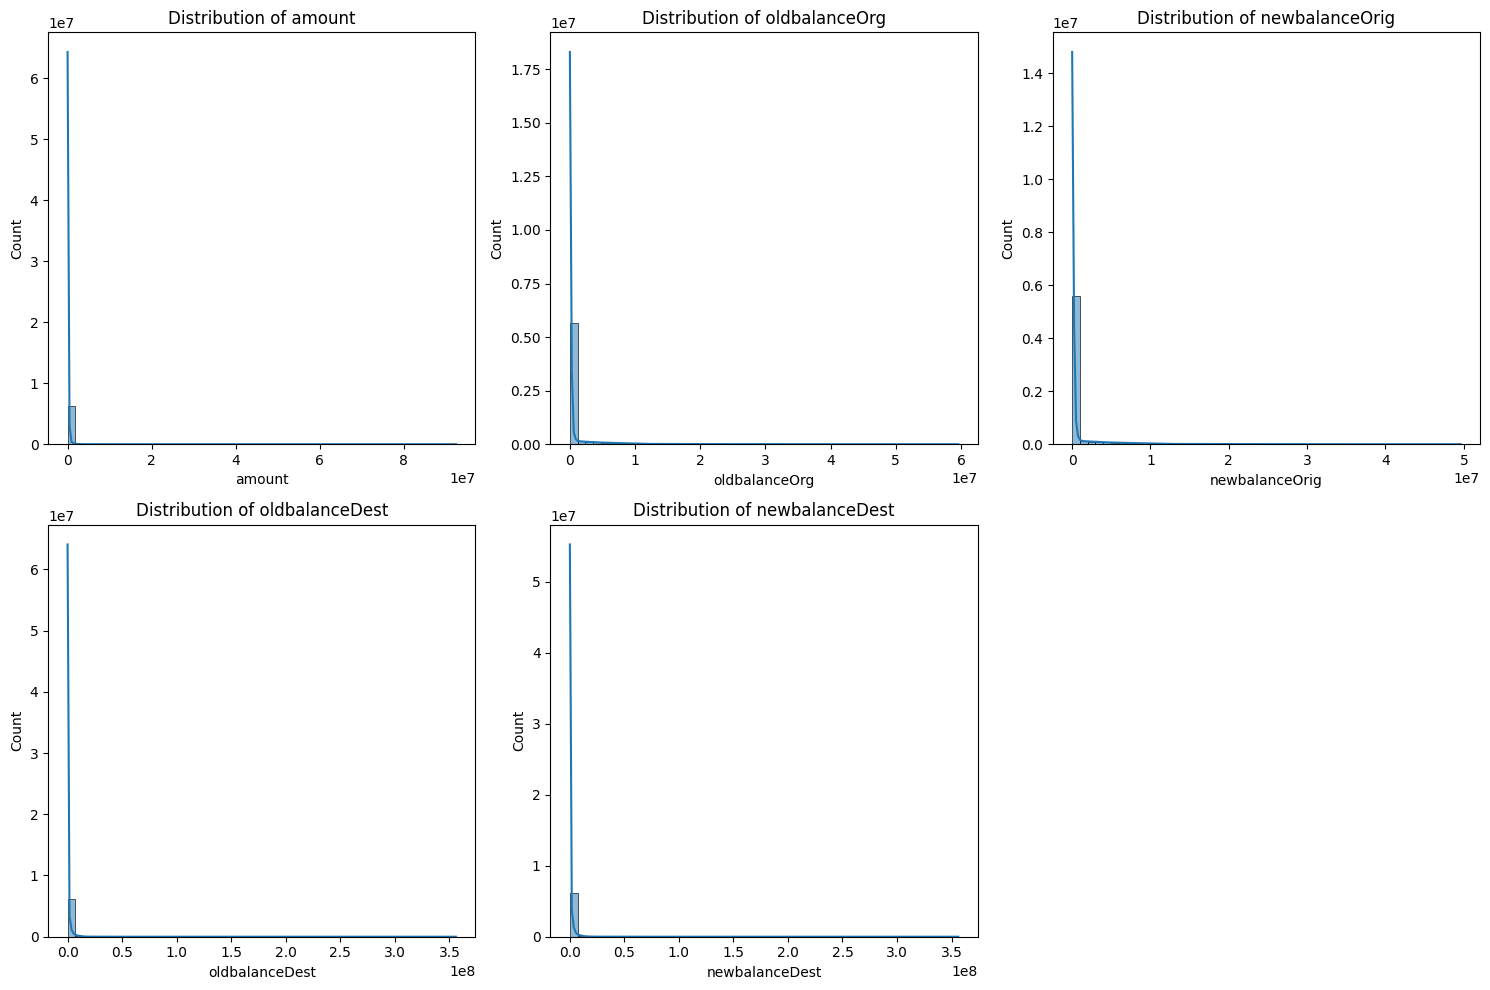

In [190]:
# Plot distributions of numerical features
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Transaction Type')

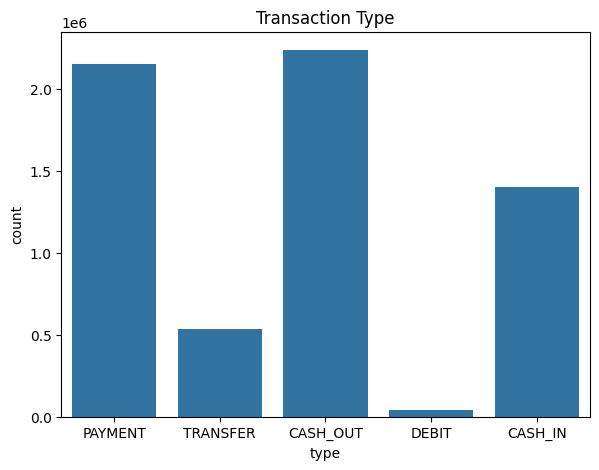

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of categorical features
plt.figure(figsize=(15, 5))

# Transaction type
plt.subplot(1, 2, 1)
sns.countplot(x='type', data=data)
plt.title('Transaction Type')

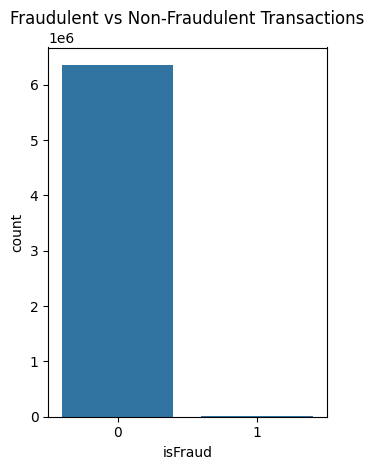

In [192]:
# Fraudulent vs Non-Fraudulent Transactions
plt.subplot(1, 2, 2)
sns.countplot(x='isFraud', data=data)
plt.title('Fraudulent vs Non-Fraudulent Transactions')

plt.tight_layout()
plt.show()

isFraud is the target column. In here, 0 refers Non Fraudulent Transaction and 1 refers Fraudulent Transaction. This graph shows the value counts for Fraudulent and Non-Fraudulent Transactions. from this graph, we can know data is imbalanced here. so we need to balance the data.

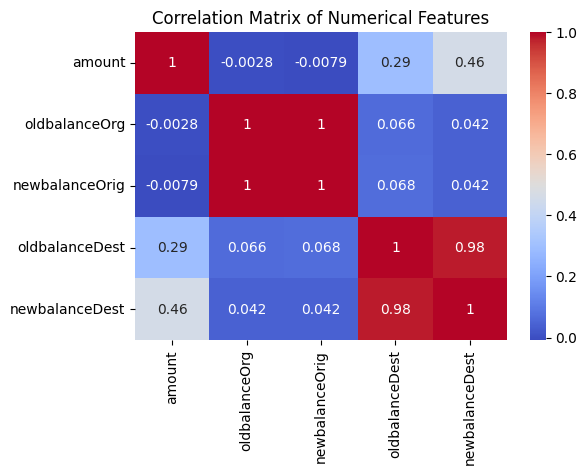

In [193]:
# Correlation matrix
plt.figure(figsize=(6, 4))
correlation_matrix = data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

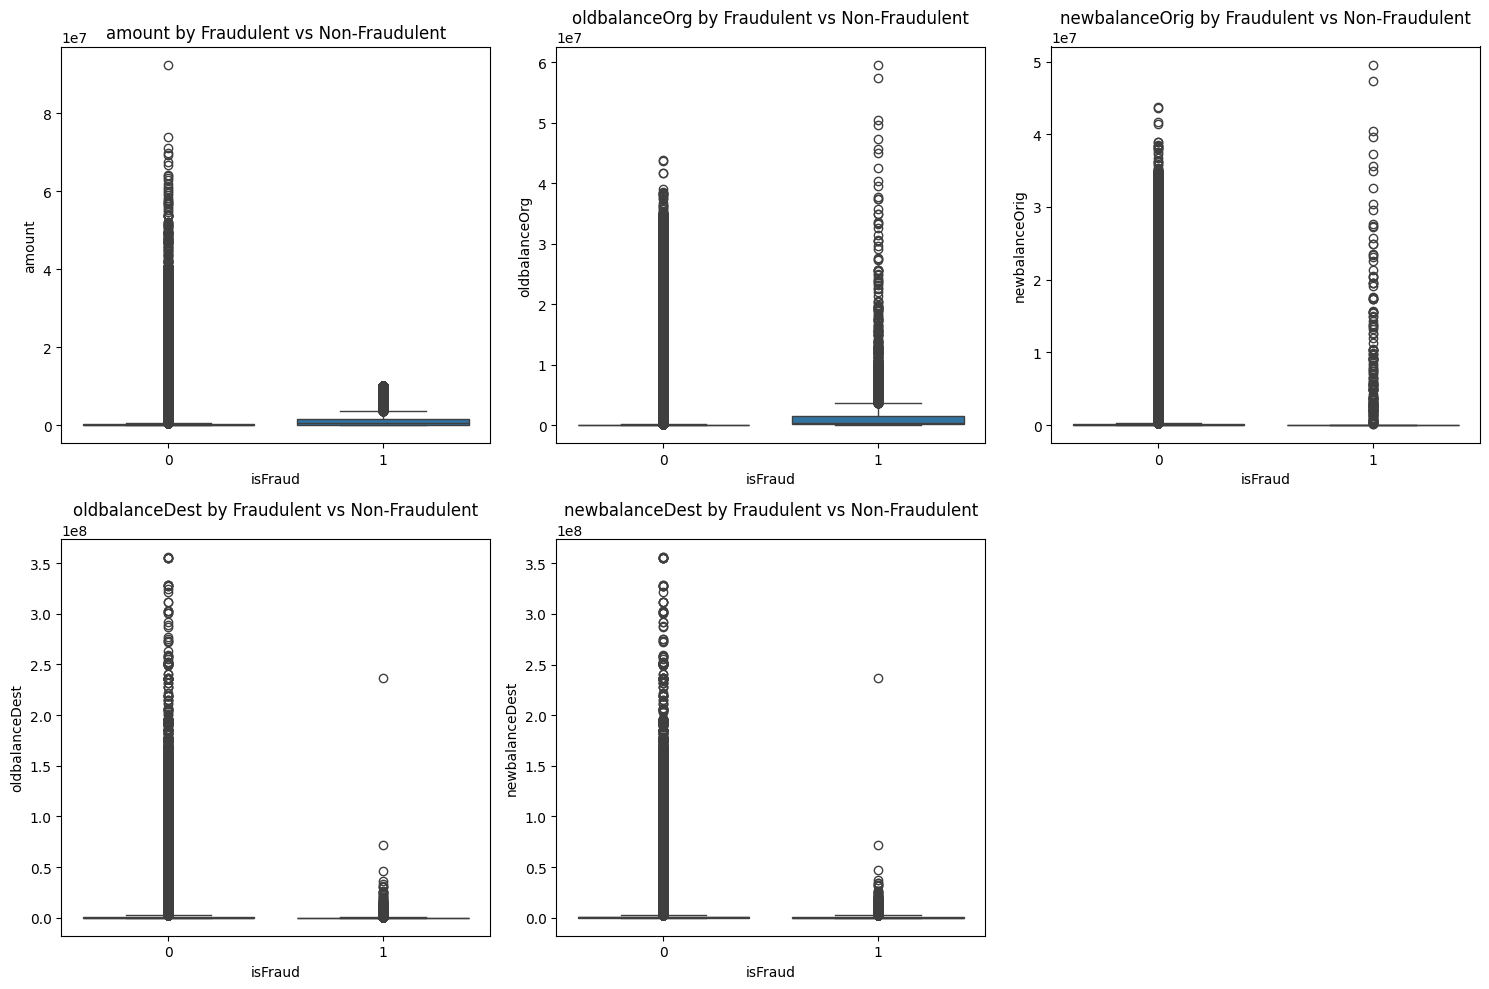

In [194]:
# Boxplots for numerical features with respect to isFraud
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='isFraud', y=feature, data=data)
    plt.title(f'{feature} by Fraudulent vs Non-Fraudulent')

plt.tight_layout()
plt.show()

For balance the data we will implement Undersampling method

#### Undersampling

In [195]:
# Separate the majority and minority classes
data_majority = data[data.isFraud == 0]
data_minority = data[data.isFraud == 1]

In [196]:
# Undersample the majority class
data_majority_undersampled = resample(data_majority, 
                                      replace=False,     # sample without replacement
                                      n_samples=len(data_minority),    # to match minority class
                                      random_state=42)   # reproducible results

# Combine the undersampled majority class with the minority class
data_undersampled = pd.concat([data_majority_undersampled, data_minority])

In [197]:
# Value counts for target column
data_undersampled["isFraud"].value_counts()

isFraud
0    8213
1    8213
Name: count, dtype: int64

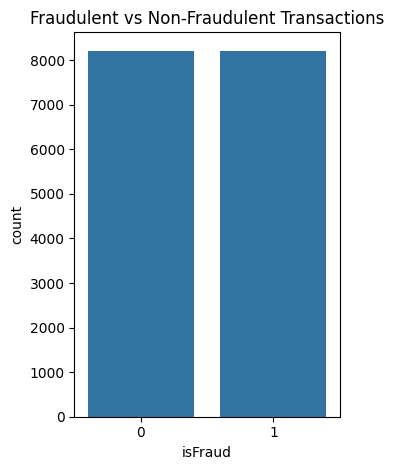

In [198]:
# Fraudulent vs Non-Fraudulent Transactions
plt.subplot(1, 2, 2)
sns.countplot(x='isFraud', data=data_undersampled)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.tight_layout()
plt.show()

Now we have balanced data (data_undersampled)

In [199]:
# row, colun counts for undersampled data
data_undersampled.shape

(16426, 11)

In [200]:
# read the data_undersampled
data_undersampled

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1777056,162,CASH_OUT,183806.32,C691771226,19391.00,0.00,C1416312719,382572.19,566378.51,0,0
1350600,137,PAYMENT,521.37,C203378011,0.00,0.00,M42773300,0.00,0.00,0,0
1991933,179,PAYMENT,3478.18,C1698571270,19853.00,16374.82,M643984524,0.00,0.00,0,0
5092368,355,PAYMENT,1716.05,C913764937,5769.17,4053.13,M1387429131,0.00,0.00,0,0
5066515,354,CASH_IN,253129.93,C2017736577,1328499.49,1581629.42,C407484102,2713220.48,2460090.55,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [201]:
# drop unneccessary columns from data_undersampled
data_undersampled.drop(columns=["step", "nameOrig", "nameDest", "isFlaggedFraud"], inplace=True)

In [202]:
# retrive first 5 rows
data_undersampled.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
1777056,CASH_OUT,183806.32,19391.00,0.00,382572.19,566378.51,0
1350600,PAYMENT,521.37,0.00,0.00,0.00,0.00,0
1991933,PAYMENT,3478.18,19853.00,16374.82,0.00,0.00,0
5092368,PAYMENT,1716.05,5769.17,4053.13,0.00,0.00,0
5066515,CASH_IN,253129.93,1328499.49,1581629.42,2713220.48,2460090.55,0


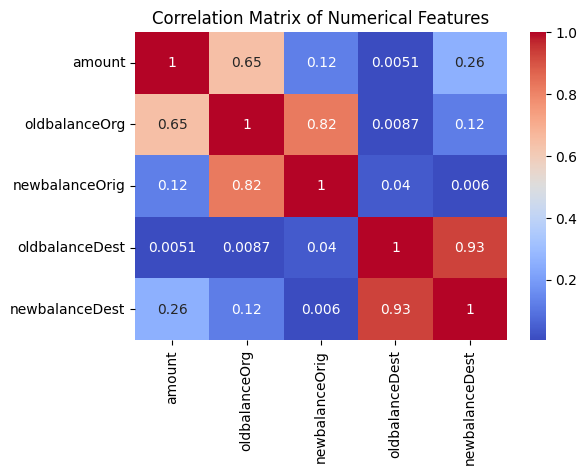

In [203]:
# Correlation matrix
plt.figure(figsize=(6, 4))
correlation_matrix = data_undersampled[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

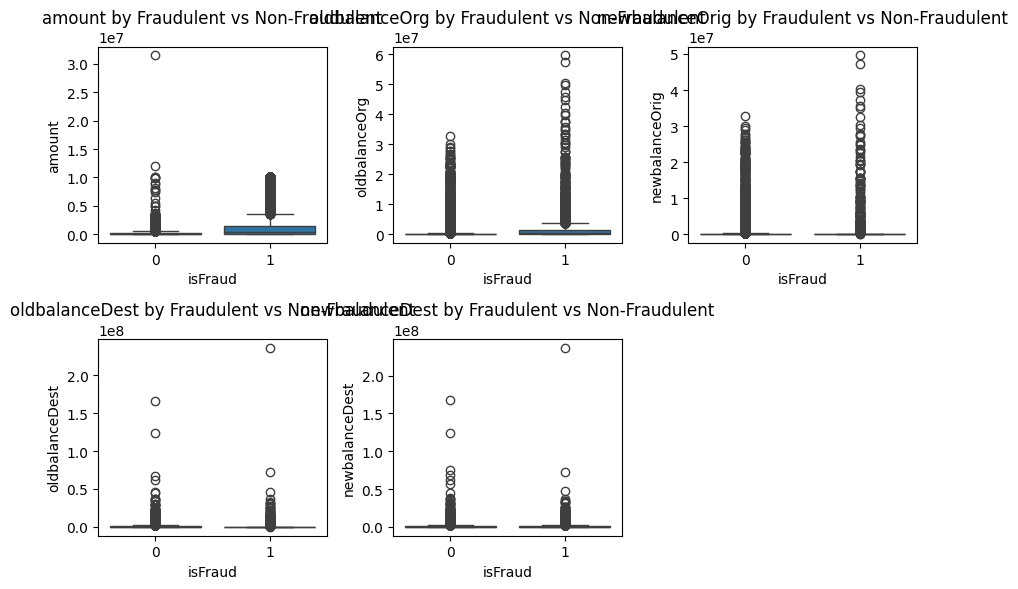

In [204]:
# Boxplots for numerical features with respect to isFraud
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(9, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='isFraud', y=feature, data=data_undersampled)
    plt.title(f'{feature} by Fraudulent vs Non-Fraudulent')

plt.tight_layout()
plt.show()

In [205]:
# information about data_undersampled
data_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16426 entries, 1777056 to 6362619
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            16426 non-null  object 
 1   amount          16426 non-null  float64
 2   oldbalanceOrg   16426 non-null  float64
 3   newbalanceOrig  16426 non-null  float64
 4   oldbalanceDest  16426 non-null  float64
 5   newbalanceDest  16426 non-null  float64
 6   isFraud         16426 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.0+ MB


We can't pass object type directly into our model. So we need to convert that object type into numerical type. for that we can LabelEncoder. It will make group every categories and give a label for each category.

In [206]:
# value counts for type column (object column)
data_undersampled["type"].value_counts()

type
CASH_OUT    7066
TRANSFER    4750
PAYMENT     2735
CASH_IN     1825
DEBIT         50
Name: count, dtype: int64

In [207]:
from sklearn.preprocessing import LabelEncoder

# initialize labelencoder
le=LabelEncoder()

# Convert object type into integer type
data_undersampled["type"]=le.fit_transform(data_undersampled["type"])

In [208]:
data_undersampled["type"].value_counts()

type
1    7066
4    4750
3    2735
0    1825
2      50
Name: count, dtype: int64

Category => Label ||

CASH_OUT => 1 | 
TRANSFER => 4 | 
PAYMENT => 3 | 
CASH_IN => 0 | 
DEBIT => 2 | 

In [209]:
# Split the data into features and target
X_undersampled = data_undersampled[["type","amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
y_undersampled = data_undersampled["isFraud"]

In [210]:
print(X_undersampled)
print("===============================")
print(y_undersampled)

         type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
1777056     1   183806.32       19391.00            0.00       382572.19   
1350600     3      521.37           0.00            0.00            0.00   
1991933     3     3478.18       19853.00        16374.82            0.00   
5092368     3     1716.05        5769.17         4053.13            0.00   
5066515     0   253129.93     1328499.49      1581629.42      2713220.48   
...       ...         ...            ...             ...             ...   
6362615     1   339682.13      339682.13            0.00            0.00   
6362616     4  6311409.28     6311409.28            0.00            0.00   
6362617     1  6311409.28     6311409.28            0.00        68488.84   
6362618     4   850002.52      850002.52            0.00            0.00   
6362619     1   850002.52      850002.52            0.00      6510099.11   

         newbalanceDest  
1777056       566378.51  
1350600            0.00  
1991933  

In [211]:
# Normalize the features
scaler=StandardScaler()
X_undersampled = scaler.fit_transform(X_undersampled)

Normalizing brings all features to a similar scale, ensuring that no single feature dominates due to its scale. It will improve model performance

In [212]:
# Save the scaler
import joblib
joblib.dump(scaler, 'MODELS/scaler.joblib')

['MODELS/scaler.joblib']

# # Data splitting

In [213]:
# Split the data into training and testing sets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_undersampled, y_undersampled, test_size=0.3, random_state=42)

#

# # Algorithm Implementation

### # unsupervised Learning Algorithm

#### k-means clustering

Best parameters for K-Means Clustering: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10}
Silhouette Score for K-Means Clustering: 0.6924244939118681


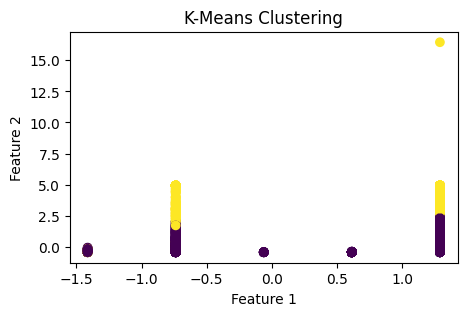

In [214]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for K-Means using GridSearchCV
param_grid_kmeans = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # range of clusters
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],  # Number of time the k-means algorithm will be run with different centroid seeds
    'max_iter': [300, 600, 900]  # Maximum number of iterations of the k-means algorithm for a single run
}

# Custom scoring function for silhouette score
def silhouette_scorer(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(X, clusters)
    return score

# GridSearchCV for K-Means
grid_kmeans = GridSearchCV(KMeans(random_state=42), param_grid_kmeans, scoring=silhouette_scorer, cv=3)
grid_kmeans.fit(X_train_under)

# Best parameters
print("Best parameters for K-Means Clustering:", grid_kmeans.best_params_)

# Predicting the clusters using the best model
best_kmeans = grid_kmeans.best_estimator_
clusters = best_kmeans.predict(X_test_under)

# Evaluating the clustering
sil_score = silhouette_score(X_test_under, clusters)
print(f'Silhouette Score for K-Means Clustering: {sil_score}')
# Plotting the clusters
plt.figure(figsize=(5, 3))
plt.scatter(X_test_under[:, 0], X_test_under[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### # Supervised Learning Algorithms

#### Decision Tree Classifier

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2479
           1       0.99      0.99      0.99      2449

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928

Accuracy for Decision Tree model: 0.9908685064935064


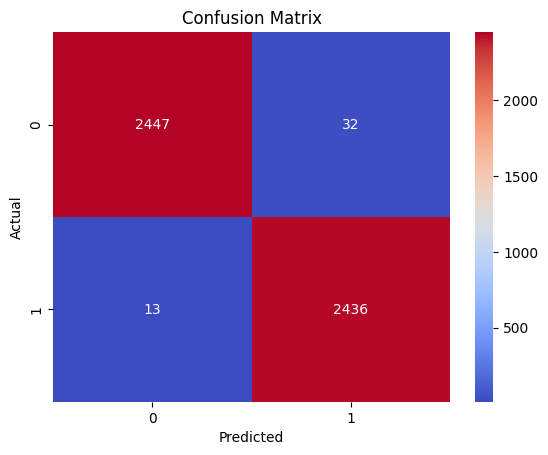

In [215]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_under, y_train_under)

# Predict on the test data
y_pred_dt = dt_clf.predict(X_test_under)

# Evaluate the model
accuracy = accuracy_score(y_test_under, y_pred_dt)
conf_matrix = confusion_matrix(y_test_under, y_pred_dt)
class_report = classification_report(y_test_under, y_pred_dt)

print(f'Classification Report for Decision Tree:\n{class_report}')
print(f'Accuracy for Decision Tree model: {accuracy}')

# Plot confusion matrix
cm = confusion_matrix(y_test_under, y_pred_dt)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression

C:\Users\0877\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\0877\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\0877\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Performance with Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2479
           1       0.95      0.85      0.90      2449

    accuracy                           0.90      4928
   macro avg       0.91      0.90      0.90      4928
weighted avg       0.91      0.90      0.90      4928

Logistic Regression Accuracy: 0.9030032467532467


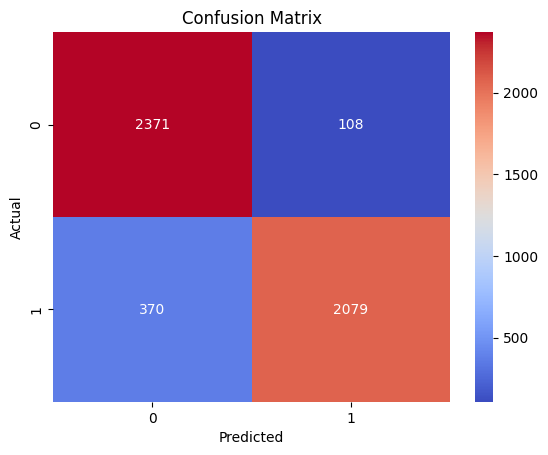

In [216]:
# Logistic Regression with Hyperparameter Tuning

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression
log_clf = LogisticRegression()

# Define the parameter grid
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' solver supports both 'l1' and 'l2' penalties
}

# Perform grid search with cross-validation
grid_log_clf = GridSearchCV(log_clf, param_grid_log, cv=3, scoring='accuracy')
grid_log_clf.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_log = grid_log_clf.predict(X_test_under)

# Print best parameters
print("Best parameters for Logistic Regression:", grid_log_clf.best_params_)

# Print performance metrics
print("Logistic Regression Performance with Hyperparameter Tuning:")
print(classification_report(y_test_under, y_pred_log))
print("Logistic Regression Accuracy:", accuracy_score(y_test_under, y_pred_log))

# Plot confusion matrix
cm = confusion_matrix(y_test_under, y_pred_log)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Random Forest Classifier

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Performance with Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2479
           1       0.99      1.00      0.99      2449

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928

Random Forest Accuracy: 0.992288961038961


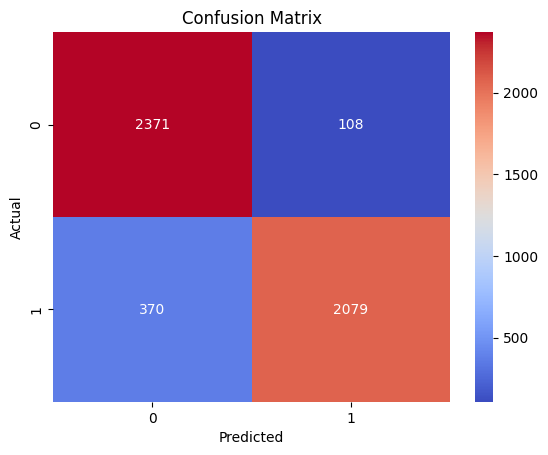

In [217]:
# Random Forest with Hyperparameter Tuning

rf_clf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf_clf = GridSearchCV(rf_clf, param_grid_rf, cv=3, scoring='accuracy')
grid_rf_clf.fit(X_train_under, y_train_under)
y_pred_rf = grid_rf_clf.predict(X_test_under)

print("Best parameters for Random Forest:", grid_rf_clf.best_params_)
print("Random Forest Performance with Hyperparameter Tuning:")
print(classification_report(y_test_under, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test_under, y_pred_rf))

# Plot confusion matrix
cm = confusion_matrix(y_test_under, y_pred_log)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gaussian Naive Bayes

Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Gaussian Naive Bayes Performance with Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.61      0.96      0.74      2479
           1       0.90      0.37      0.52      2449

    accuracy                           0.66      4928
   macro avg       0.75      0.66      0.63      4928
weighted avg       0.75      0.66      0.63      4928

Gaussian Naive Bayes Accuracy: 0.6649756493506493


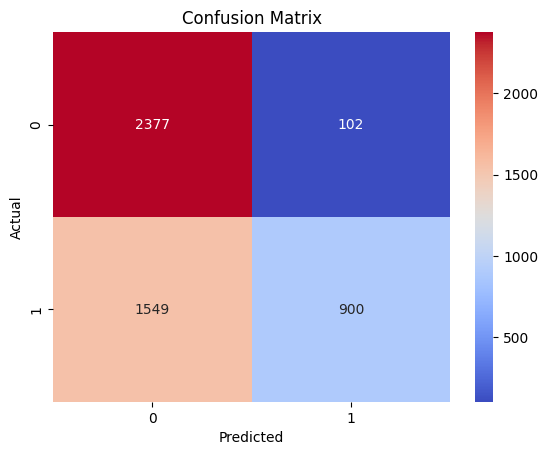

In [218]:
# GaussianNB with Hyperparameter Tuning

from sklearn.naive_bayes import GaussianNB

# Define the Naive Bayes model
nb_clf = GaussianNB()

# Define the parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize GridSearchCV
grid_nb_clf = GridSearchCV(estimator=nb_clf, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the model
grid_nb_clf.fit(X_train_under, y_train_under)

# Get the best parameters and model
best_params_nb = grid_nb_clf.best_params_
best_nb_model = grid_nb_clf.best_estimator_

# Make predictions
y_pred_nb = best_nb_model.predict(X_test_under)

# Evaluate the model
print("Best parameters for Naive Bayes:", best_params_nb)
print("Gaussian Naive Bayes Performance with Hyperparameter Tuning:")
print(classification_report(y_test_under, y_pred_nb))
print("Gaussian Naive Bayes Accuracy:", accuracy_score(y_test_under, y_pred_nb))

# Plot confusion matrix
cm = confusion_matrix(y_test_under, y_pred_nb)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model comparison

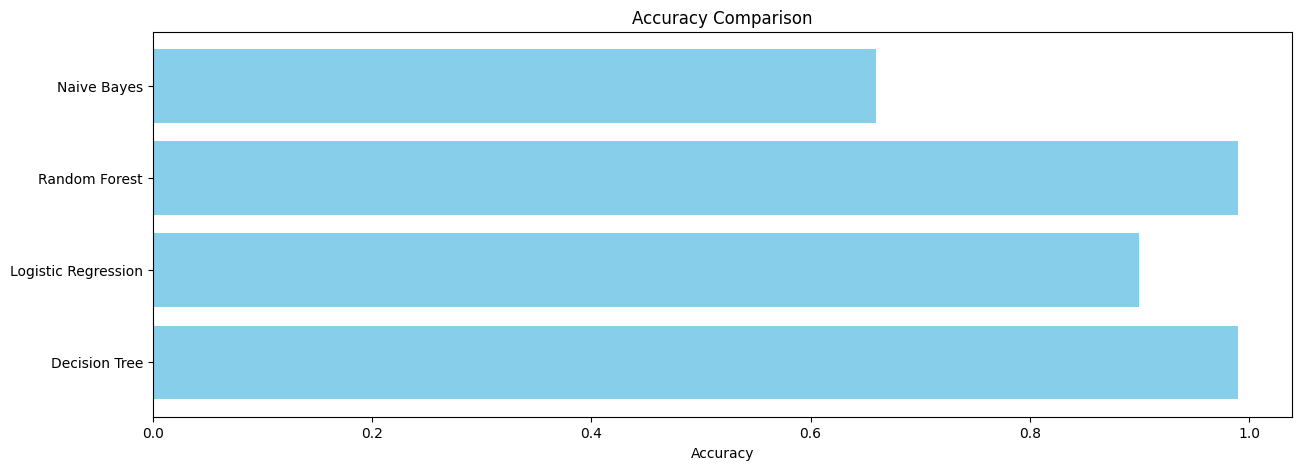

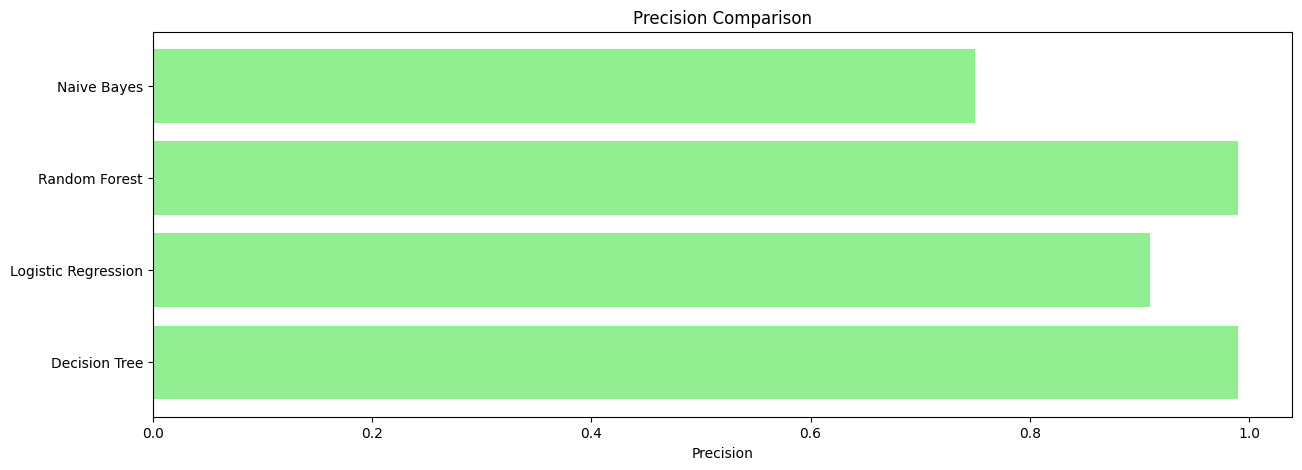

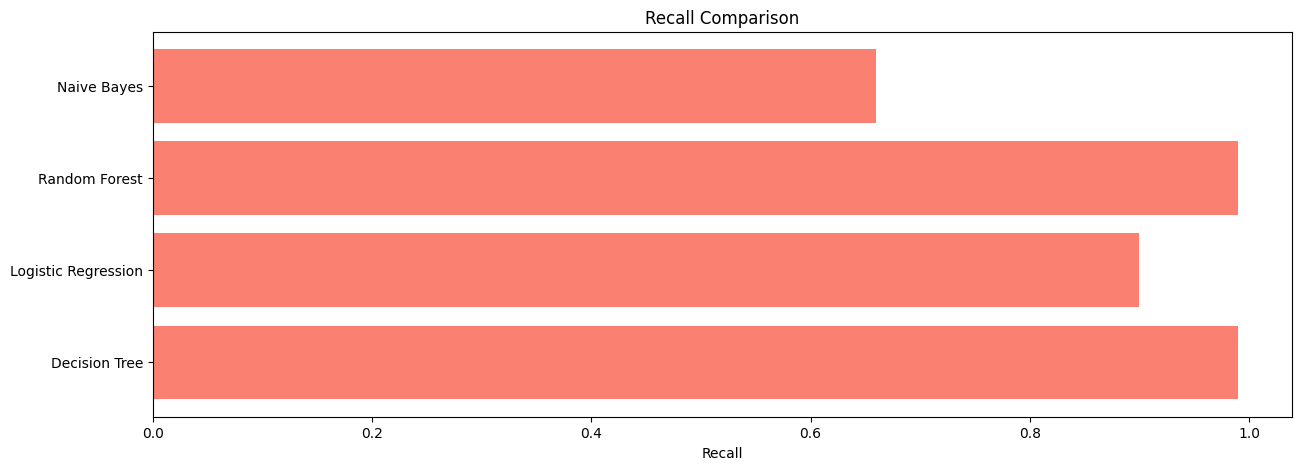

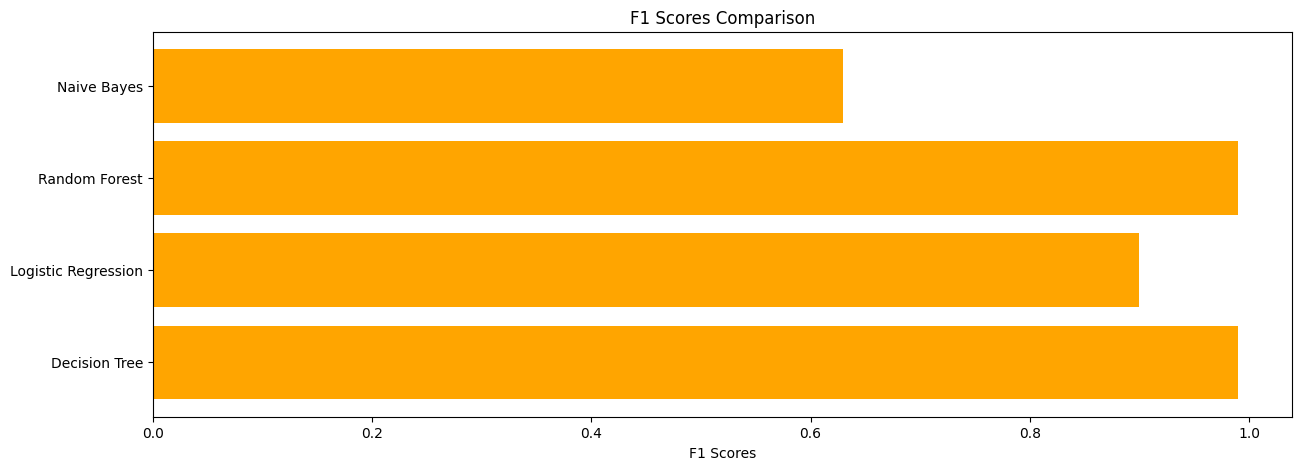

In [219]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Data for comparison plots
models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'Naive Bayes']
accuracies = [0.99, 0.90, 0.99, 0.66]
precision = [0.99, 0.91, 0.99, 0.75]
recall = [0.99, 0.90, 0.99, 0.66]
f1_scores = [0.99, 0.90, 0.99, 0.63]

def complarison_plot(name, color, values):
    plt.figure(figsize=(50, 5))
    plt.subplot(1, 3, 1)
    plt.barh(models, values, color=color)
    plt.xlabel(name)
    plt.title(f'{name} Comparison')

complarison_plot(name="Accuracy", color="Skyblue", values=accuracies)
complarison_plot(name="Precision", color="lightgreen", values=precision)
complarison_plot(name="Recall", color="salmon", values=recall)
complarison_plot(name="F1 Scores", color="orange", values=f1_scores)

In [220]:
dt_best_model = dt_clf # dt_clf is the best model already
log_best_model = grid_log_clf.best_estimator_
rf_best_model = grid_rf_clf.best_estimator_
nb_best_model = grid_nb_clf.best_estimator_

#### ROC curve
The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a binary classification model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

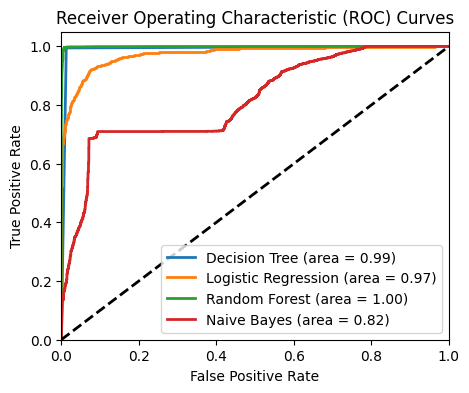

In [221]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

# Calculate ROC curves and AUC for each model
dt_clf_fpr, dt_clf_tpr, _ = roc_curve(y_test_under, dt_best_model.predict_proba(X_test_under)[:,1])
dt_clf_auc = auc(dt_clf_fpr, dt_clf_tpr)

log_clf_fpr, log_clf_tpr, _ = roc_curve(y_test_under, log_best_model.predict_proba(X_test_under)[:,1])
log_clf_auc = auc(log_clf_fpr, log_clf_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test_under, rf_best_model.predict_proba(X_test_under)[:,1])
rf_auc = auc(rf_fpr, rf_tpr)

nb_fpr, nb_tpr, _ = roc_curve(y_test_under, nb_best_model.predict_proba(X_test_under)[:,1])
nb_auc = auc(nb_fpr, nb_tpr)

# Plot all ROC curves
plt.figure(figsize=(5, 4))
plot_roc_curve(dt_clf_fpr, dt_clf_tpr, dt_clf_auc, 'Decision Tree')
plot_roc_curve(log_clf_fpr, log_clf_tpr, log_clf_auc, 'Logistic Regression')
plot_roc_curve(rf_fpr, rf_tpr, rf_auc, 'Random Forest')
plot_roc_curve(nb_fpr, nb_tpr, nb_auc, 'Naive Bayes')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# # Model Saving

In [222]:
# Save the best models

import joblib

joblib.dump(log_best_model, 'MODELS/logistic_regression_model.joblib')
joblib.dump(rf_best_model, 'MODELS/random_forest_model.joblib')
joblib.dump(dt_best_model, 'MODELS/decision_tree_model.joblib')
joblib.dump(nb_best_model, 'MODELS/naive_bytes_model.joblib')

['MODELS/naive_bytes_model.joblib']

#

# # Model Prediction

In [223]:
import joblib

# Load the scaler
scaler = joblib.load(r"MODELS\scaler.pkl")

# Load the Model
model = joblib.load(r"MODELS\logistic_regression_model.pkl")

classes = {0 : "Non Fraudulent Transaction", 1 : "Fraudulent Transaction"}

def prediction_function(inputs):
    scaled_features = scaler.transform(inputs)
    prediction = model.predict(scaled_features)
    result = classes[prediction[0]]
    print("Predicted result: ", result)

In [224]:
inputs = [[3, 7817.71, 53860, 46042.29, 0, 0]]
prediction_function(inputs)

Predicted result:  Non Fraudulent Transaction


C:\Users\0877\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [225]:
inputs = [[54664, 4, 496, 494, 6949, 94]]
prediction_function(inputs)

Predicted result:  Fraudulent Transaction


C:\Users\0877\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
